# Config

In [1]:
# Libraries
from shapely import wkb
from shapely import from_wkb
import matplotlib.pyplot as plt

import geopandas as gpd
import duckdb
import duckdb
import geopandas as gpd
import sys
import os
# go up one level from notebooks/ and into src/
from config import INTERIM_DATA_DIR,PROCESSED_DATA_DIR

# Load data

## Places

In [2]:
# 1️⃣ Connect + load extensions
duckdb.install_extension('httpfs')
duckdb.install_extension('spatial')
duckdb.load_extension('httpfs')
duckdb.load_extension('spatial')

# 2️⃣ S3 config
duckdb.sql("""
SET s3_region='us-west-2';
SET s3_url_style='path';
SET s3_use_ssl=true;
""")

# 3️⃣ Bounding box
xmin, ymin = 2.10, 41.35
xmax, ymax = 2.25, 41.45
# 4️⃣ Query Overture "places"
query = f"""
SELECT
    id,
    names,
    categories,
    basic_category AS category,
    confidence,
    ST_AsWKB(geometry) AS geometry
  FROM read_parquet(
  's3://overturemaps-us-west-2/release/2025-10-22.0/theme=places/type=place/*.parquet'
)
WHERE geometry IS NOT NULL
    AND bbox.xmin BETWEEN {xmin} AND {xmax}
    AND bbox.ymin BETWEEN {ymin} AND {ymax}
"""




In [3]:
# 5️⃣ Read into Pandas DataFrame
df = duckdb.sql(query).df()

In [4]:
# 6️⃣ Convert WKB geometry to Shapely
df["geometry"] = df["geometry"].apply(lambda x: wkb.loads(bytes(x)) if isinstance(x, (bytes, bytearray)) else None)

# 7️⃣ Wrap in GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# 8️⃣ Inspect and plot
places = gdf.copy()
gdf.head()



,id,names,categories,category,confidence,geometry
0,911ab9de-4bf9-4804-9010-86b426d5189e,"{'primary': 'Beach Tennis Barcelona Club', 'co...","{'primary': 'gym', 'alternate': ['sports_and_r...",gym,0.618890,POINT (2.20971 41.39629)
1,413ca989-cdf4-4331-85bf-6760310876f1,"{'primary': 'Prime Training', 'common': None, ...","{'primary': 'fitness_trainer', 'alternate': None}",sport_fitness_facility,0.541414,POINT (2.21002 41.39577)
2,0b4fb796-3696-4cfa-9490-dd120afa080f,"{'primary': 'Playa Del Garraf', 'common': None...","{'primary': 'beach', 'alternate': ['hotel', 'b...",None,0.618890,POINT (2.20875 41.3953)
3,4d93a70a-4fe1-4e95-8b1e-d121bd02d9f9,"{'primary': 'Multiverse BeachVolley', 'common'...","{'primary': 'volleyball_club', 'alternate': ['...",sport_recreation_club,0.770000,POINT (2.20854 41.39575)
4,2efbcbfb-528f-4216-beb1-4a223c3fdfd0,{'primary': 'Phoenix Beach Volleyball Barcelon...,"{'primary': 'sports_club_and_league', 'alterna...",sport_recreation_club,0.982836,POINT (2.20867 41.39585)


### Plots

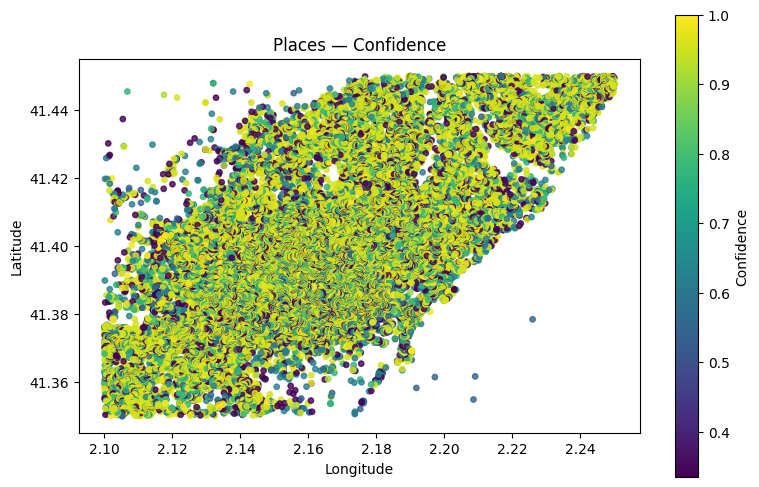

In [5]:
# Plots and visualizations

fig, ax = plt.subplots(figsize=(8, 8))
places.plot(
    column="confidence",
    cmap="viridis",
    ax=ax,
    markersize=15,
    alpha=0.8,
    legend=True,
    legend_kwds={"label": "Confidence", "shrink": 0.6},
)
ax.set_title("Places — Confidence")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal")
plt.tight_layout()

### Save results

In [6]:
#Save results and figures
places.to_parquet(INTERIM_DATA_DIR / "overture_places.parquet")
places.to_file(INTERIM_DATA_DIR / "overture_places.geojson", driver="GeoJSON")

## Base

Overture base has several use cases that could be beneficial for the AI tool. Firstly, let's look at land_use

In [7]:
# 1️⃣ Connect + load extensions
duckdb.install_extension('httpfs')
duckdb.install_extension('spatial')
duckdb.load_extension('httpfs')
duckdb.load_extension('spatial')

# 2️⃣ S3 config
duckdb.sql("""
SET s3_region='us-west-2';
SET s3_url_style='path';
SET s3_use_ssl=true;
""")

# 3️⃣ Bounding box
xmin, ymin = 2.10, 41.35
xmax, ymax = 2.25, 41.45
# 4️⃣ Query Overture "places"
query = f"""
SELECT
    id,
    names,
    theme,
    sources,
    subtype
    confidence,
    ST_AsWKB(geometry) AS geometry
  FROM read_parquet(
  's3://overturemaps-us-west-2/release/2025-10-22.0/theme=base/type=land_use/*.parquet'
)
WHERE geometry IS NOT NULL
    AND bbox.xmin BETWEEN {xmin} AND {xmax}
    AND bbox.ymin BETWEEN {ymin} AND {ymax}
"""




In [8]:
# 5️⃣ Read into Pandas DataFrame
land_use = duckdb.sql(query).df()

In [9]:
# 6️⃣ Convert WKB geometry to Shapely
land_use["geometry"] = land_use["geometry"].apply(lambda x: wkb.loads(bytes(x)) if isinstance(x, (bytes, bytearray)) else None)

# 7️⃣ Wrap in GeoDataFrame
gdf_landuse = gpd.GeoDataFrame(land_use, geometry="geometry", crs="EPSG:4326")

# 8️⃣ Inspect and plot
places = gdf_landuse.copy()
gdf_landuse.head()

,id,names,theme,sources,confidence,geometry
0,cd7d8aae-d5d0-38ec-b19a-10890e59e17d,"{'primary': 'Espigó d'Antoni Gutierrez Diaz ""E...",base,"[{'property': '', 'dataset': 'OpenStreetMap', ...",pedestrian,"POLYGON ((2.21131 41.39554, 2.21113 41.39541, ..."
1,37e19dcd-48d1-3e22-8335-fa26e33ff3c7,"{'primary': 'Espigó d'Antoni Gutierrez Diaz ""E...",base,"[{'property': '', 'dataset': 'OpenStreetMap', ...",pedestrian,"POLYGON ((2.21033 41.39621, 2.21016 41.39633, ..."
2,0075b052-c4ad-3870-a037-26aab4c71257,"{'primary': 'Espigó d'Antoni Gutierrez Diaz ""E...",base,"[{'property': '', 'dataset': 'OpenStreetMap', ...",pedestrian,"POLYGON ((2.21009 41.39603, 2.21088 41.39542, ..."
3,231a5f3b-2f54-3acf-bc76-1eb144aa2a50,<NA>,base,"[{'property': '', 'dataset': 'OpenStreetMap', ...",park,"POLYGON ((2.20551 41.39607, 2.20594 41.39575, ..."
4,d58297e9-103c-328d-a955-7d2e3c72bc08,<NA>,base,"[{'property': '', 'dataset': 'OpenStreetMap', ...",managed,"POLYGON ((2.20599 41.39571, 2.20643 41.39537, ..."


### Plots


<Axes: >

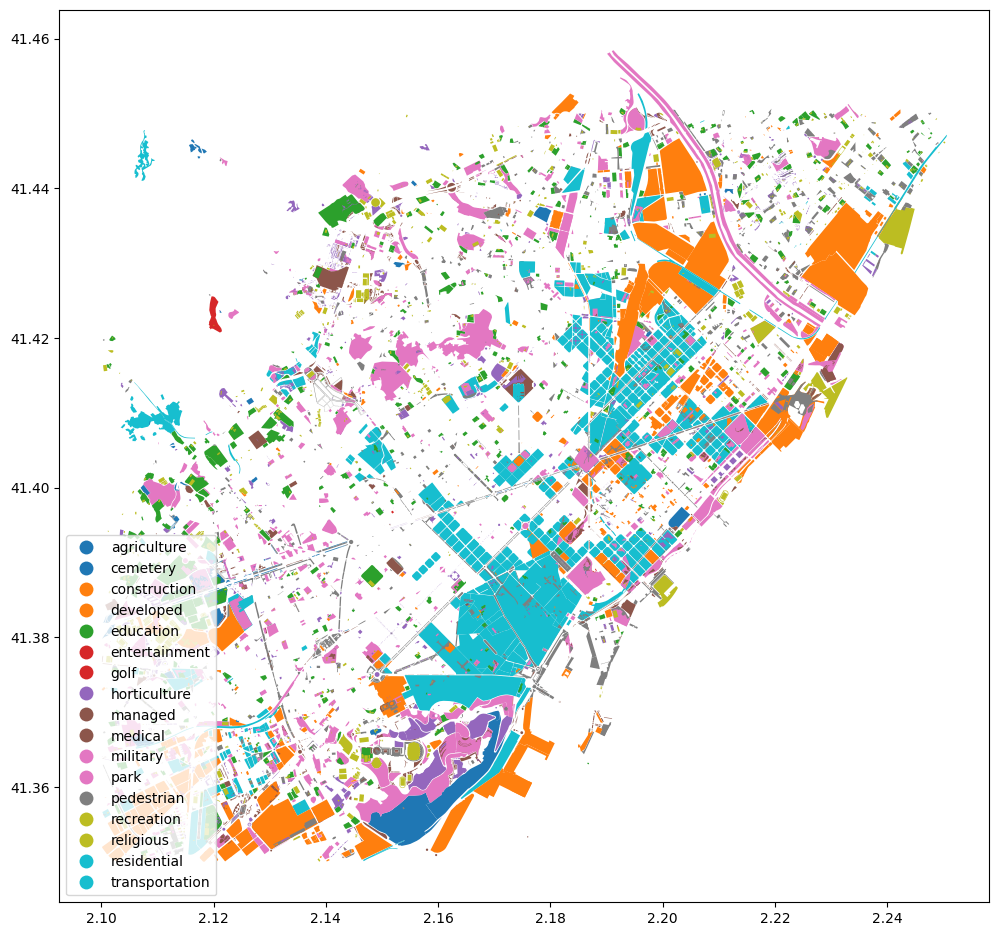

In [10]:
f, ax = plt.subplots(figsize=(12, 12))
gdf_landuse.plot(column="confidence", 
                 legend=True, ax =ax,
                 legend_kwds={"loc": "lower left"}  )
#add colourbar


### Save results

In [15]:
gdf_landuse.to_parquet(INTERIM_DATA_DIR/"overture_landuse.parquet")

## Buildings

In [12]:
# 1️⃣ Connect + load extensions
duckdb.install_extension('httpfs')
duckdb.install_extension('spatial')
duckdb.load_extension('httpfs')
duckdb.load_extension('spatial')

# 2️⃣ S3 config
duckdb.sql("""
SET s3_region='us-west-2';
SET s3_url_style='path';
SET s3_use_ssl=true;
""")

# 3️⃣ Bounding box
xmin, ymin = 2.10, 41.35
xmax, ymax = 2.25, 41.45
# 4️⃣ Query Overture "places"
query = f"""
SELECT
    id,
    names,
    class,
    sources,
    subtype,
    ST_AsWKB(geometry) AS geometry
  FROM read_parquet(
  's3://overturemaps-us-west-2/release/2025-10-22.0/theme=buildings/type=building/*.parquet'
)
WHERE geometry IS NOT NULL
    AND bbox.xmin BETWEEN {xmin} AND {xmax}
    AND bbox.ymin BETWEEN {ymin} AND {ymax}
"""




In [13]:
buildings = duckdb.sql(query).df()

In [14]:
# 6️⃣ Convert WKB geometry to Shapely
buildings["geometry"] = buildings["geometry"].apply(lambda x: wkb.loads(bytes(x)) if isinstance(x, (bytes, bytearray)) else None)

# 7️⃣ Wrap in GeoDataFrame
gdf = gpd.GeoDataFrame(buildings, geometry="geometry", crs="EPSG:4326")

# 8️⃣ Inspect and plot
places = gdf.copy()
gdf.head()

,id,names,class,sources,subtype,geometry
0,94fc79f8-1f18-4443-8ac3-b55144ea280f,<NA>,None,"[{'property': '', 'dataset': 'OpenStreetMap', ...",None,"POLYGON ((2.20594 41.39526, 2.20586 41.3952, 2..."
1,a986d3df-b245-48db-be69-6fd26dd22287,"{'primary': 'Piscis', 'common': None, 'rules':...",None,"[{'property': '', 'dataset': 'OpenStreetMap', ...",None,"POLYGON ((2.20674 41.39521, 2.20672 41.39522, ..."
2,ff885b3d-5180-4b83-bf9d-aee1dc8816bf,<NA>,None,"[{'property': '', 'dataset': 'Microsoft ML Bui...",None,"POLYGON ((2.20806 41.39542, 2.20801 41.39538, ..."
3,9bbfa146-ef9b-4e31-be62-5650d3528525,<NA>,None,"[{'property': '', 'dataset': 'Microsoft ML Bui...",None,"POLYGON ((2.20654 41.39438, 2.20656 41.39437, ..."
4,a845cf2f-017d-439d-83ae-44524ff41243,"{'primary': 'Can Fisher', 'common': None, 'rul...",None,"[{'property': '', 'dataset': 'OpenStreetMap', ...",commercial,"POLYGON ((2.20638 41.39468, 2.2063 41.39474, 2..."


### Plots

<Axes: >

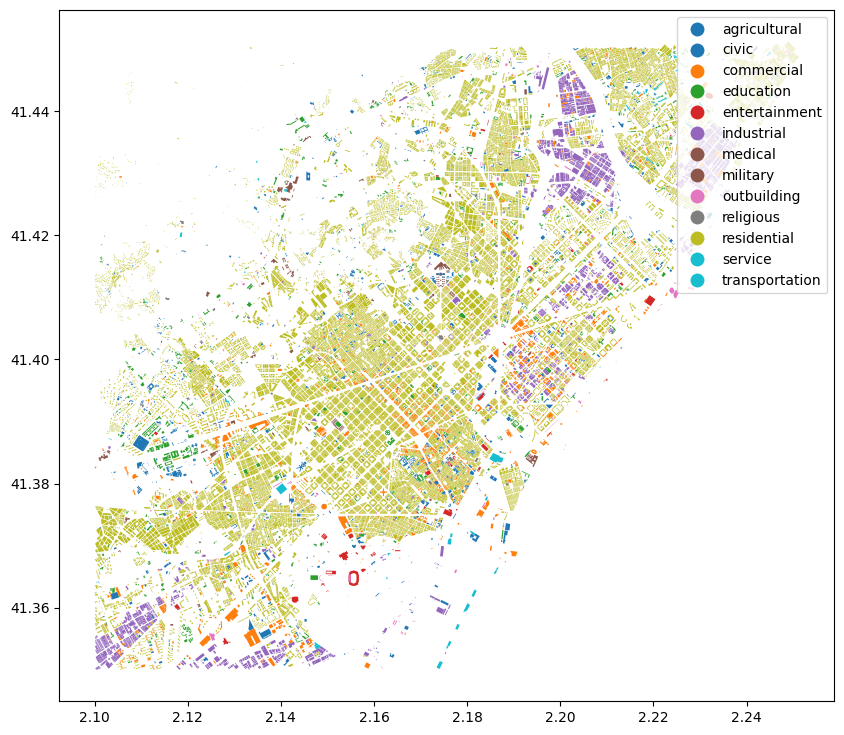

In [16]:
gdf.plot(column="subtype", figsize=(10,10), legend=True)

### Save results

In [17]:
gdf.to_parquet(INTERIM_DATA_DIR/"overture_buildings.parquet")